# Explore MEG associations

In [47]:
%cd work/notebooks

# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

[Errno 2] No such file or directory: 'work/notebooks'
/home/jovyan/work/notebooks
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Attaching package: ‘ggpp’



    annotate




In [48]:
dme_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

# dme_ds8 = gradientVersion().fit('hcp_ds8')
# dme_ds5 = gradientVersion().fit('hcp_ds5')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [79]:
hcp_scores = dme_3d_ds5.clean_scores()
# null_scores = np.load("../outputs/permutations/hcp_3d_ds5_spin_5000_v2.npy")
null_scores = np.load("../outputs/permutations/hcp_3d_ds5_sim_5000_v3.npy")
# null_scores = np.load("../outputs/permutations/hcp_ds8_spin_5000.npy")

# hcp_scores = pd.concat({
#     'DS5':dme_ds5.clean_scores(),
#     'DS8':dme_ds8.clean_scores(),
#     '3donors DS5':dme_3d_ds5.clean_scores()
# }).reset_index(0).rename({'level_0':'version'},axis=1)

In [55]:
weights = dme_3d_ds5.weights.iloc[:,:3].set_axis(['G1','G2','G3'],axis=1)

## MEG connectivity

matrices from Karahan 2022

In [83]:
from scipy.io import loadmat
meg_data = loadmat("../data/MEG_karahan_2022.mat")
meg_names = [x[0] for x in meg_data['FrequenciesStr'][0]]
meg_mats = meg_data['A'][0][0][0][0]
meg = dict(zip(meg_names, meg_mats))

Sum to get connectivity

In [84]:
meg_connectivity = pd.DataFrame({name:mat.sum(1) for name,mat in meg.items()})
meg_connectivity.shape

(230, 4)

ROI labels don't perfectly match so extract list of matching labels

In [85]:
mapping = loadmat("../data/parcellations/karahan2022_HCP_atlas_sampling.mat")
retained_labels = np.hstack(np.char.split(np.hstack(mapping['ROIlabels'].flatten()), sep=' + '))
meglabels = pd.Series(retained_labels).str.extract('_(.*)_')[0].replace({'7PL':'7Pl'}).rename(None)
np.setdiff1d(get_labels_hcp(), meglabels)

array(['H'], dtype=object)

Use mapping matrix to convert to original HCP parcellation and rename with matching labels

In [86]:
meg_connectivity_hcp = ((mapping['reg_meg2dwi'] @ meg_connectivity)
                        .set_axis(meglabels).iloc[:179].reindex(get_labels_hcp()[:180])
                        .apply(lambda x: (x-np.mean(x))/np.std(x))
)

In [91]:
meg_connectivity_hcp.join(hcp_scores.set_index('label')).corr().round(2)

,4-8,8-13,13-30,30-100,G1,G2,G3
4-8,1.00,0.67,0.64,-0.24,0.21,0.14,-0.16
8-13,0.67,1.00,0.45,-0.12,0.32,0.25,0.00
13-30,0.64,0.45,1.00,0.14,0.15,0.13,-0.10
30-100,-0.24,-0.12,0.14,1.00,-0.13,0.03,0.01
G1,0.21,0.32,0.15,-0.13,1.00,-0.00,-0.00
G2,0.14,0.25,0.13,0.03,-0.00,1.00,0.00
G3,-0.16,0.00,-0.10,0.01,-0.00,0.00,1.00


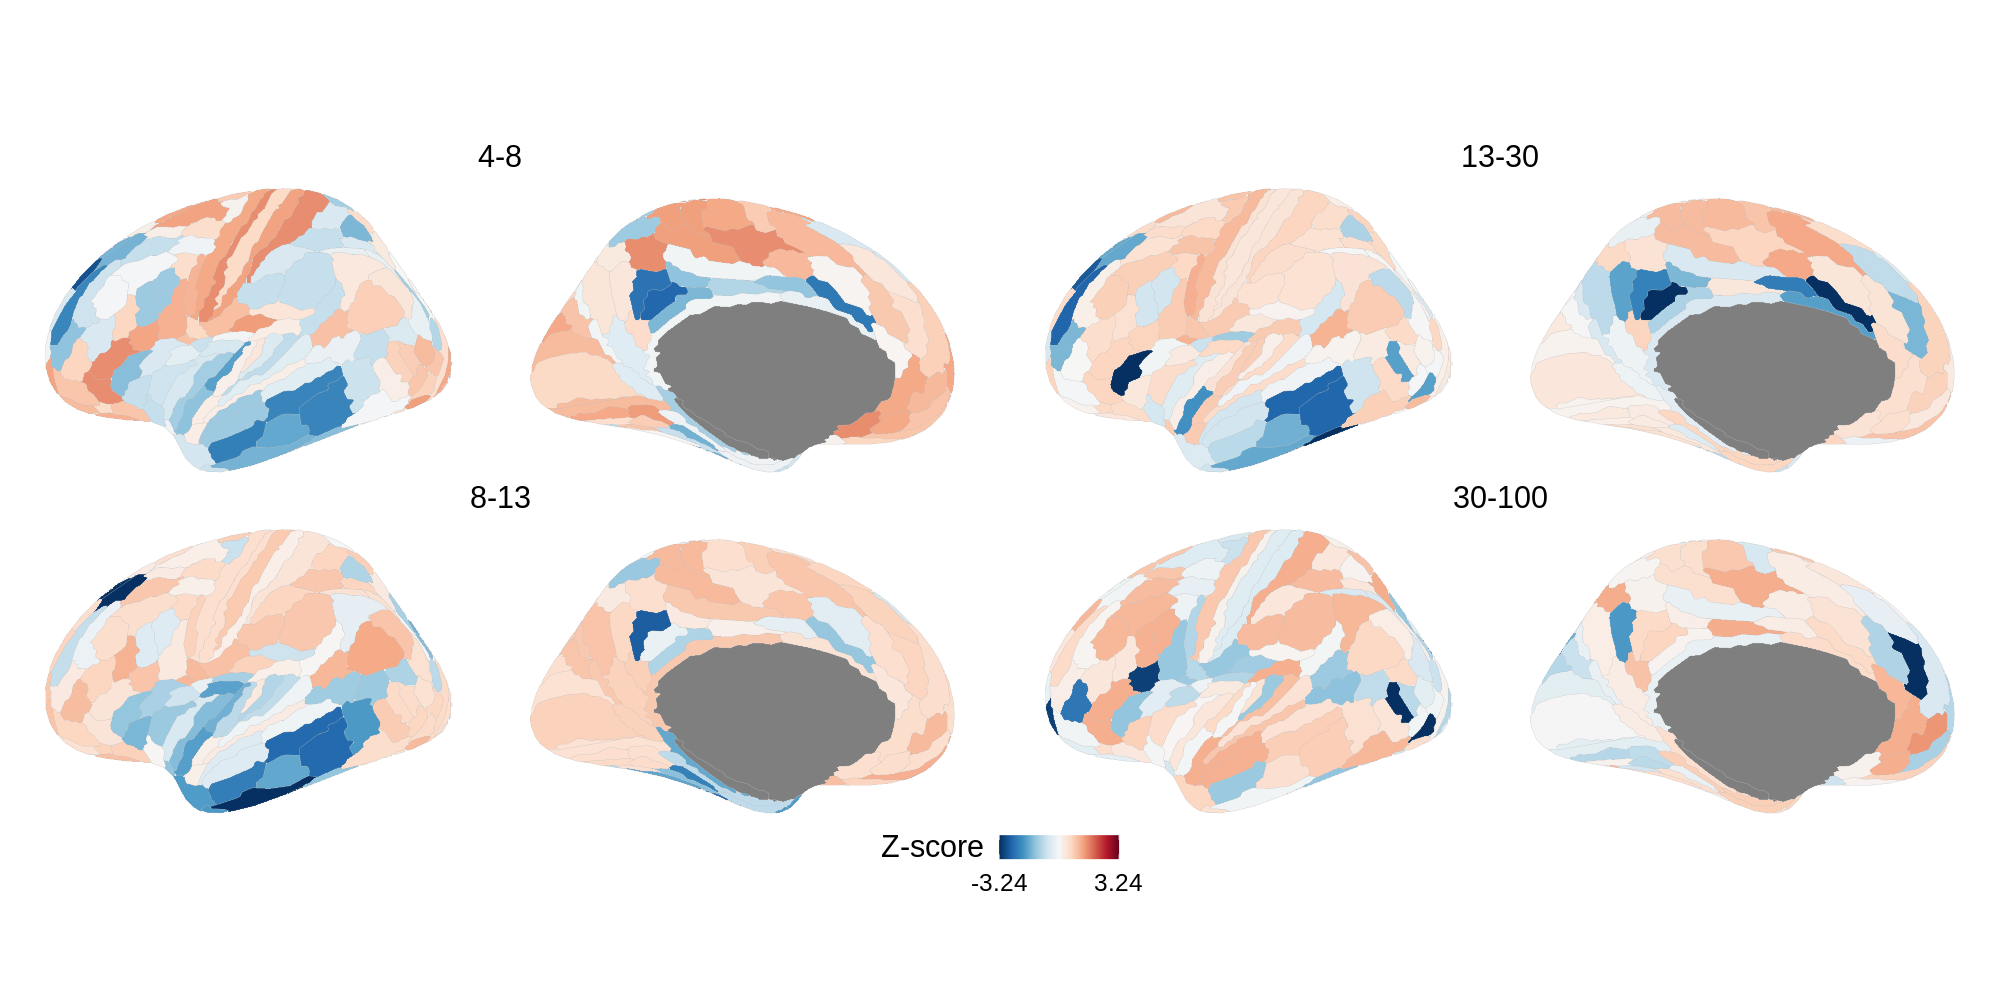

In [153]:
%%R -i meg_connectivity_hcp -w 20 -h 10 -u in -r 100
source("../code/plot_maps.R")
plot_maps(meg_connectivity_hcp)

## MEG maps

In [59]:
meg_maps = (pd.read_csv("../data/meg_HCPS1200.csv", index_col=0)
            .set_index(get_labels_hcp()[:180])
            .drop(['myelinmap','thickness','megtimescale'], axis=1)
            .apply(lambda x: (x-np.mean(x))/np.std(x))
)
meg_maps

,megalpha,megbeta,megdelta,meggamma1,meggamma2,megtheta
label,,,,,,
V1,1.346305,-0.950642,-0.518782,-1.171798,-0.802466,-0.914991
MST,1.164284,-0.718874,-0.540194,-1.223103,-0.805902,-0.609940
V6,1.788186,-0.323085,-1.233396,-1.179002,-1.144581,-1.100668
V2,1.355669,-0.836594,-0.571531,-1.013988,-0.649012,-0.949788
V3,1.506634,-0.729623,-0.726571,-0.963216,-0.653666,-1.103299
...,...,...,...,...,...,...
STSva,-0.019938,-0.915546,0.818639,-0.124024,0.743163,-0.223971
TE1m,0.239870,-0.964469,0.450684,-0.197460,0.812896,-0.239697
PI,-0.058895,-0.725672,0.807087,-0.193573,0.418686,-0.169800


In [60]:
meg_maps_scatter = (meg_maps
    .melt(ignore_index=False, var_name='map', value_name='map_score')
    .join(hcp_scores.set_index('label'))
    .melt(ignore_index=False, id_vars=['map','map_score'], var_name='G', value_name='G_score')
    .dropna(how='any')
)

In [70]:
null_scores.shape

(137, 3, 5000)

In [80]:
meg_maps_null_p = (corr_nulls_from_grads(null_scores, hcp_scores, meg_maps, method='pearsonr',
                                         adjust_by_label=True)
                .join(meg_maps_scatter.groupby(['map','G']).min(), on=('map','G'))
                .rename({'map_score':'y', 'G_score':'x'},axis=1)
)

In [81]:
meg_maps_null_p = (meg_maps_null_p
                    .drop(['y','x'], axis=1)
                    .join(meg_maps_scatter.groupby(['map','G'])
                          .agg({'map_score':'min', 'G_score':'min'}), on=('map','G'))
                    .rename({'map_score':'y', 'G_score':'x'},axis=1)
)

/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '




`geom_smooth()` using formula = 'y ~ x'


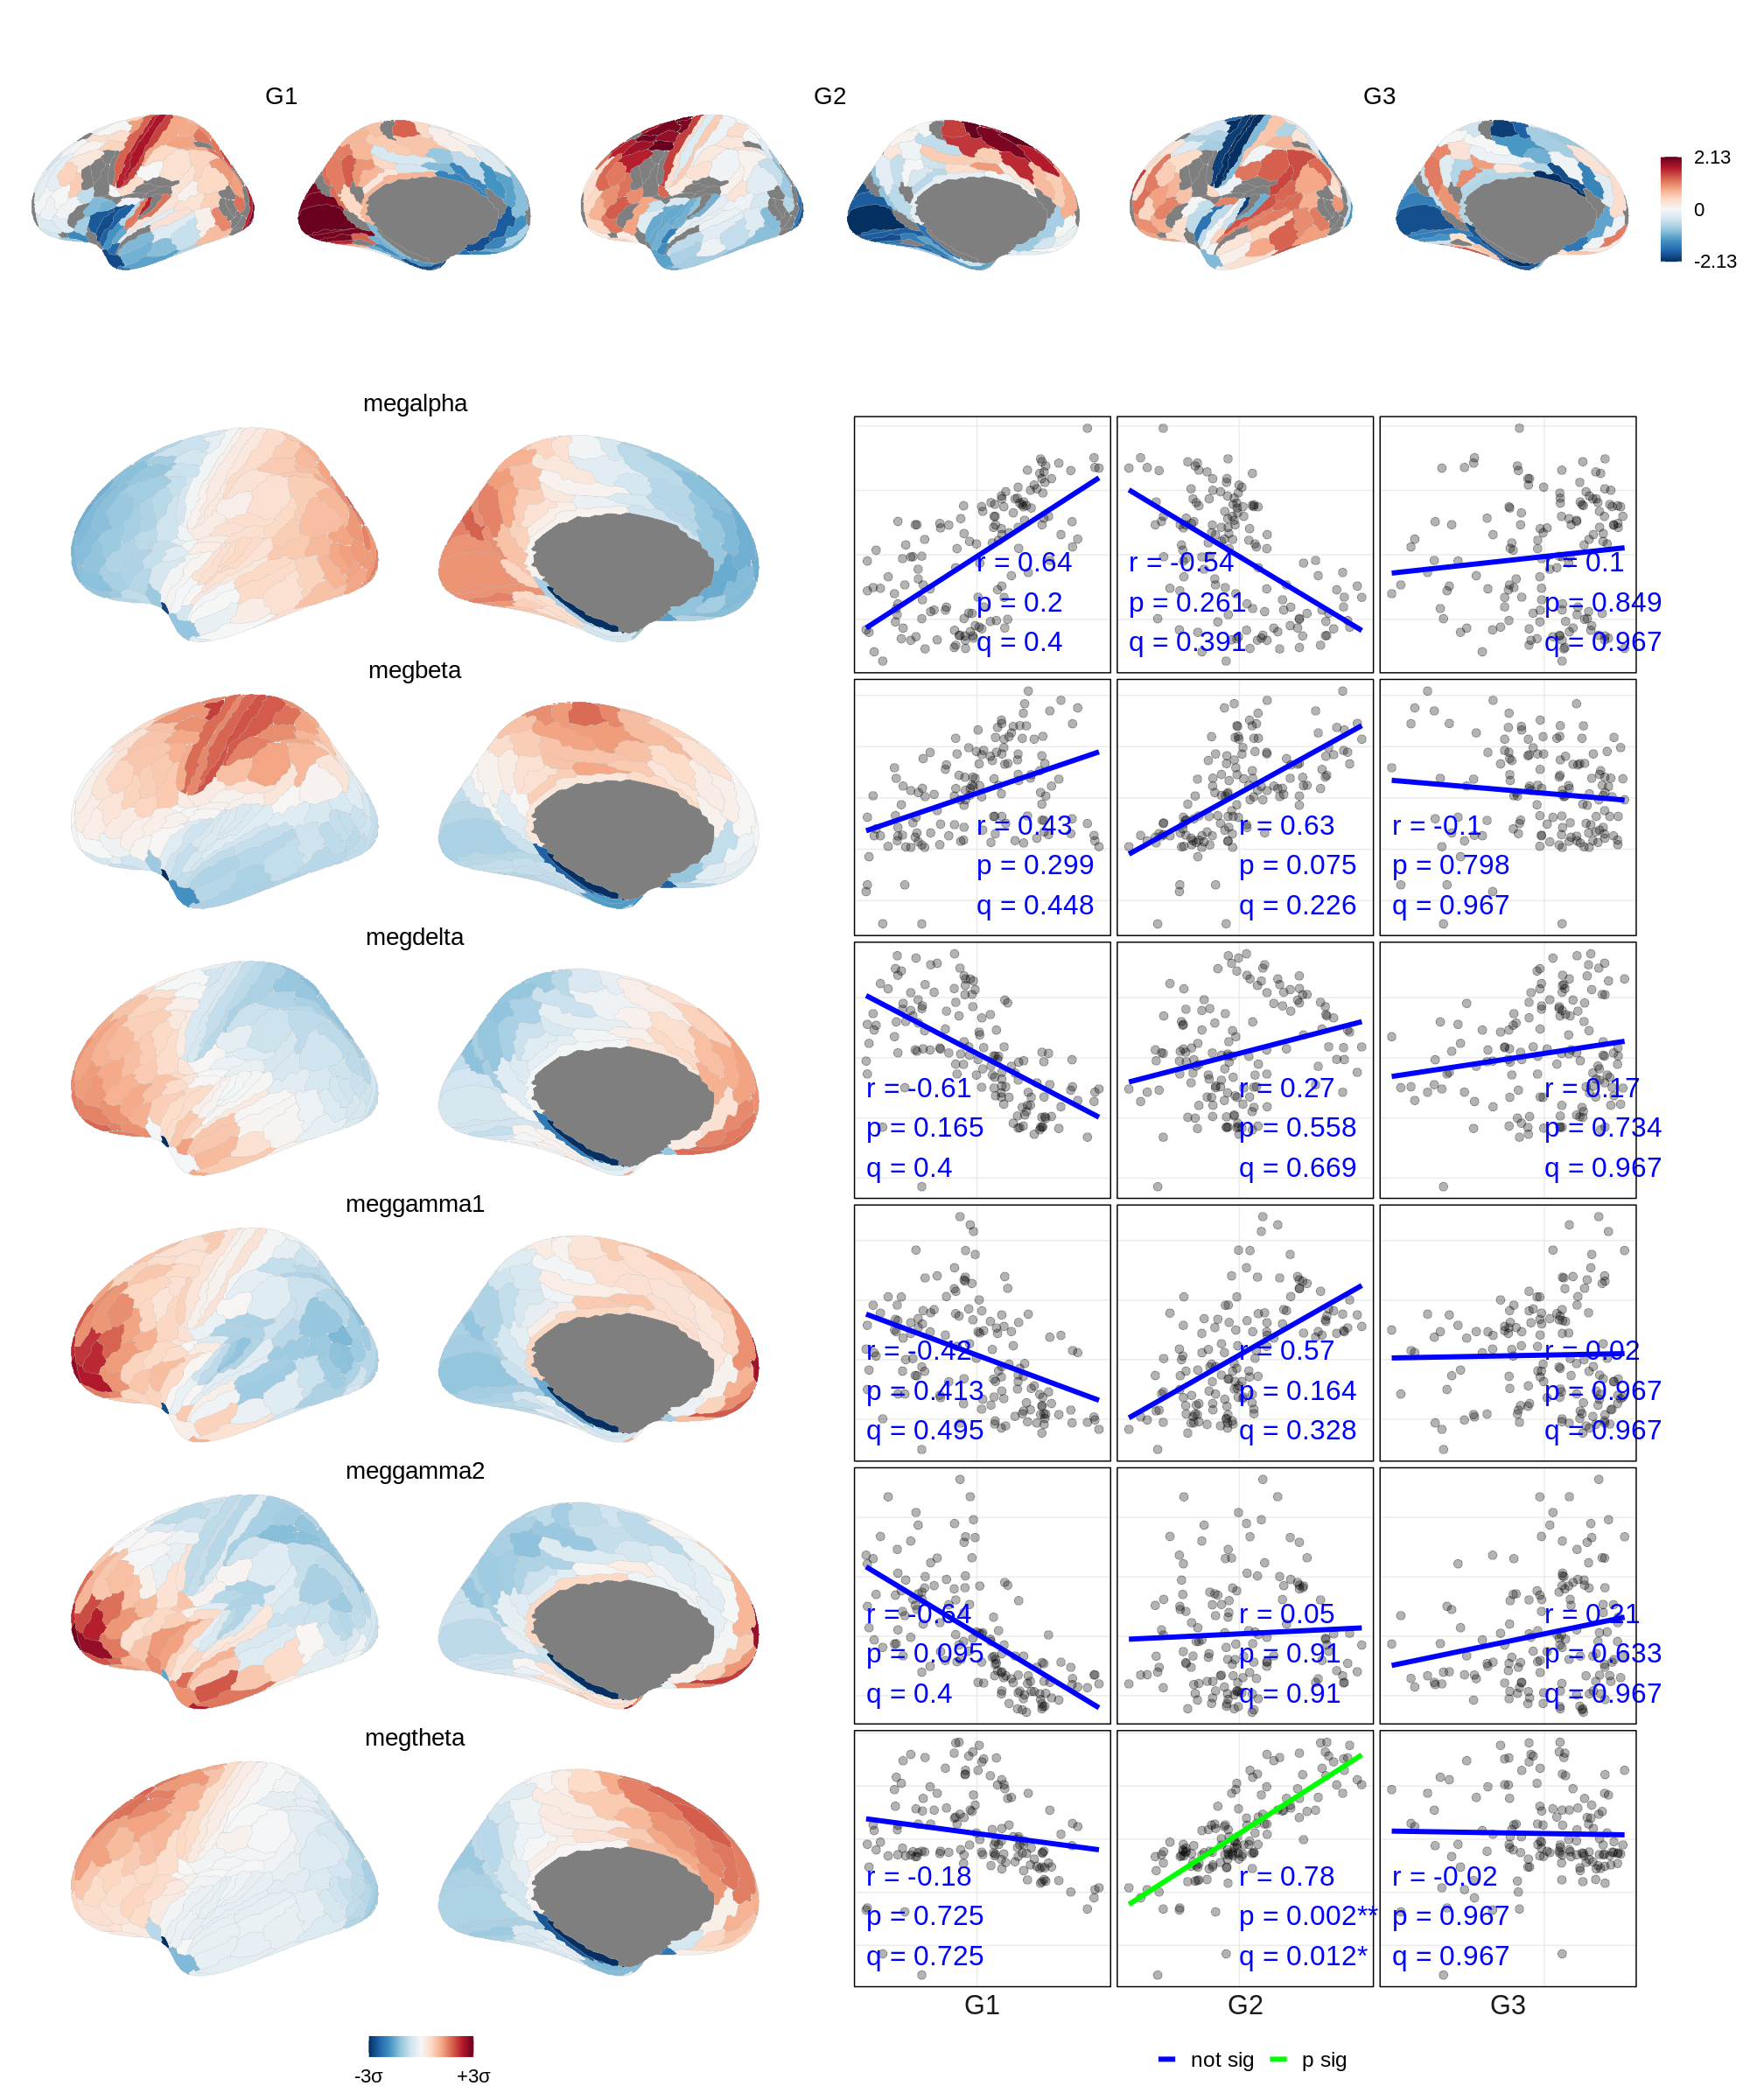

In [82]:
%%R -i hcp_scores -i meg_maps -i meg_maps_scatter -i meg_maps_null_p -w 20 -h 24 --units in -r 100
source("../code/plot_maps.R")
g0 <- plot_hcp_wide(hcp_scores)
g1 <- plot_maps(meg_maps, ncol=1) & theme(strip.text=element_text(size=22))
g2 <- plot_maps_scatter_explore(meg_maps_scatter, meg_maps_null_p) & theme(text=element_text(size=22), strip.text.y.left=element_blank())
(g0 / (g1 + g2)) + plot_layout(heights=c(1,6))

## (once off) process MEG spectra into HCP

In [2]:
from neuromaps.datasets import fetch_atlas
fslr = fetch_atlas('fsLR', '32k')

 ...done. (2 seconds, 0 min)
Extracting data from /home/jovyan/neuromaps-data/599046a594e0e45c04e90291c2348cbe/fsLR32k.tar.gz..... done.


In [6]:
# from neuromaps.datasets import fetch_annotation
from neuromaps.datasets import fetch_annotation, available_annotations
# available_annotations()
meg_maps = fetch_annotation(source='hcps1200')

 ...done. (1 seconds, 0 min)


In [8]:
meg_maps = {name[1]:data for name,data in meg_maps.items()}
meg_maps

{'megalpha': ['/home/jovyan/neuromaps-data/annotations/hcps1200/megalpha/fsLR/source-hcps1200_desc-megalpha_space-fsLR_den-4k_hemi-L_feature.func.gii',
  '/home/jovyan/neuromaps-data/annotations/hcps1200/megalpha/fsLR/source-hcps1200_desc-megalpha_space-fsLR_den-4k_hemi-R_feature.func.gii'],
 'megbeta': ['/home/jovyan/neuromaps-data/annotations/hcps1200/megbeta/fsLR/source-hcps1200_desc-megbeta_space-fsLR_den-4k_hemi-L_feature.func.gii',
  '/home/jovyan/neuromaps-data/annotations/hcps1200/megbeta/fsLR/source-hcps1200_desc-megbeta_space-fsLR_den-4k_hemi-R_feature.func.gii'],
 'megdelta': ['/home/jovyan/neuromaps-data/annotations/hcps1200/megdelta/fsLR/source-hcps1200_desc-megdelta_space-fsLR_den-4k_hemi-L_feature.func.gii',
  '/home/jovyan/neuromaps-data/annotations/hcps1200/megdelta/fsLR/source-hcps1200_desc-megdelta_space-fsLR_den-4k_hemi-R_feature.func.gii'],
 'meggamma1': ['/home/jovyan/neuromaps-data/annotations/hcps1200/meggamma1/fsLR/source-hcps1200_desc-meggamma1_space-fsLR_den-

In [19]:
nib.load(meg_maps['megalpha'][0]).agg_data().shape

(4002,)

In [87]:
hcp_img = (annot_to_gifti("../data/parcellations/lh.HCPMMP1.annot")[0],annot_to_gifti("../data/parcellations/rh.HCPMMP1.annot")[0])

from neuromaps.transforms import fslr_to_fsaverage, fsaverage_to_fslr
# hcp_fsLR = fsaverage_to_fslr(hcp_img, '4k', hemi='LR', method='nearest')

In [44]:
hcp_fsLR[0].agg_data()

array([ 34.,  52.,  12., ..., 133., 133., 133.], dtype=float32)

In [79]:
# nib.load(meg_maps['megalpha'][0]).agg_data()
from neuromaps.images import load_gifti
gifti=meg_maps['megalpha']
np.hstack([load_gifti(img).agg_data() for img in gifti])

array([0.30698058, 0.32872456, 0.26092964, ..., 0.31584653, 0.32754862,
       0.32326072], dtype=float32)

In [90]:
hcp_img[0].agg_data().shape

(163842,)

In [91]:
# from neuromaps.nulls.spins import parcels_to_vertices, vertices_to_parcels
from neuromaps.parcellate import Parcellater
# hcp_img = annot_to_gifti("../data/parcellations/lh.HCPMMP1.annot")

meg_maps_hcp = {}
for name, map in meg_maps.items():
    # meg_maps_hcp[name] = vertices_to_parcels(map, hcp_fsLR)
    meg_maps_hcp[name] = Parcellater(hcp_img, space='fsaverage', resampling_target='parcellation').fit().transform(map, space='fsLR')

In [99]:
pd.DataFrame(meg_maps_hcp).to_csv("../data/meg_HCPS1200.csv")